# Inflation Prediction Using Global Economic Indicators (2010–2023)

**Objective:**

Predict inflation rates for various countries using global economic indicators from 2010 to 2023. This project covers data exploration, feature selection, model building, evaluation, and deployment of a simple prediction UI.

## Import Libraries

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, precision_score

# For deployment UI
import gradio as gr

## Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('economic_indicators_dataset_2010_2023.csv')

# Display first few rows
df.head()

# Show basic info
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   500 non-null    object 
 1   Country                500 non-null    object 
 2   Inflation Rate (%)     500 non-null    float64
 3   GDP Growth Rate (%)    500 non-null    float64
 4   Unemployment Rate (%)  500 non-null    float64
 5   Interest Rate (%)      500 non-null    float64
 6   Stock Index Value      500 non-null    float64
dtypes: float64(5), object(2)
memory usage: 27.5+ KB


Date                     0
Country                  0
Inflation Rate (%)       0
GDP Growth Rate (%)      0
Unemployment Rate (%)    0
Interest Rate (%)        0
Stock Index Value        0
dtype: int64

## Data Cleaning

In [3]:
# Handle missing values (if any)
df = df.dropna()

# Convert 'Date' to datetime and extract year/month if useful
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Normalize/scale numeric features
features = ['GDP Growth Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)', 'Stock Index Value', 'Year', 'Month']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

print("Numeric features are scaled to have zero mean and unit variance.")

Numeric features are scaled to have zero mean and unit variance.


## Exploratory Data Analysis (EDA)

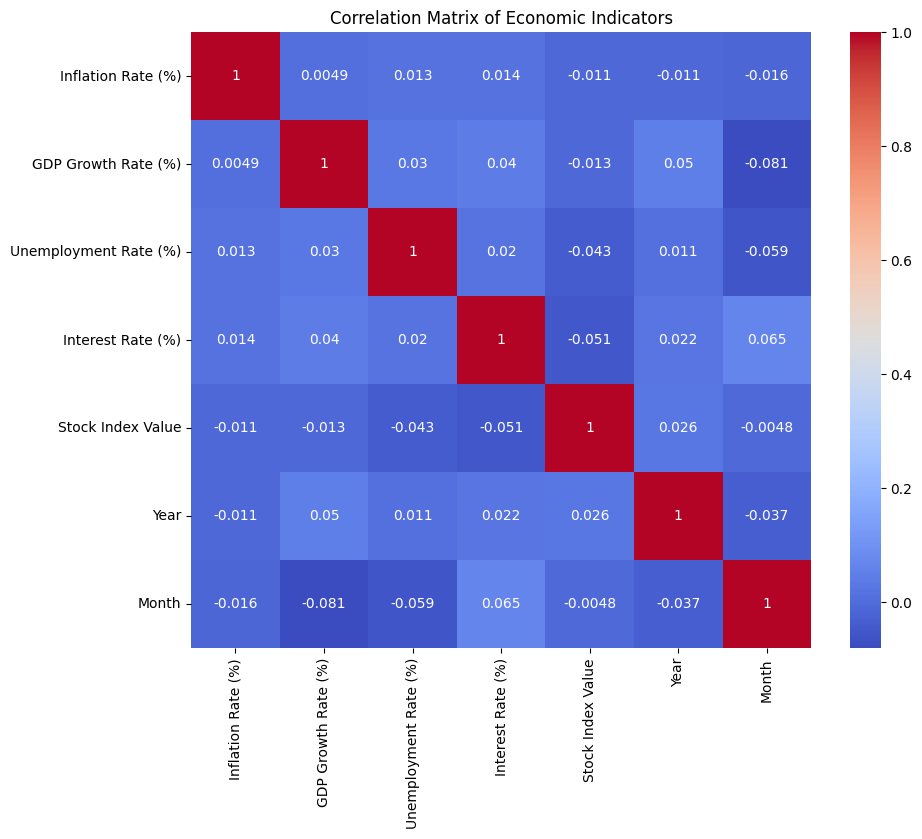

In [4]:
# Correlation matrix (numeric columns only)
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Economic Indicators')
plt.show()

## Feature Selection

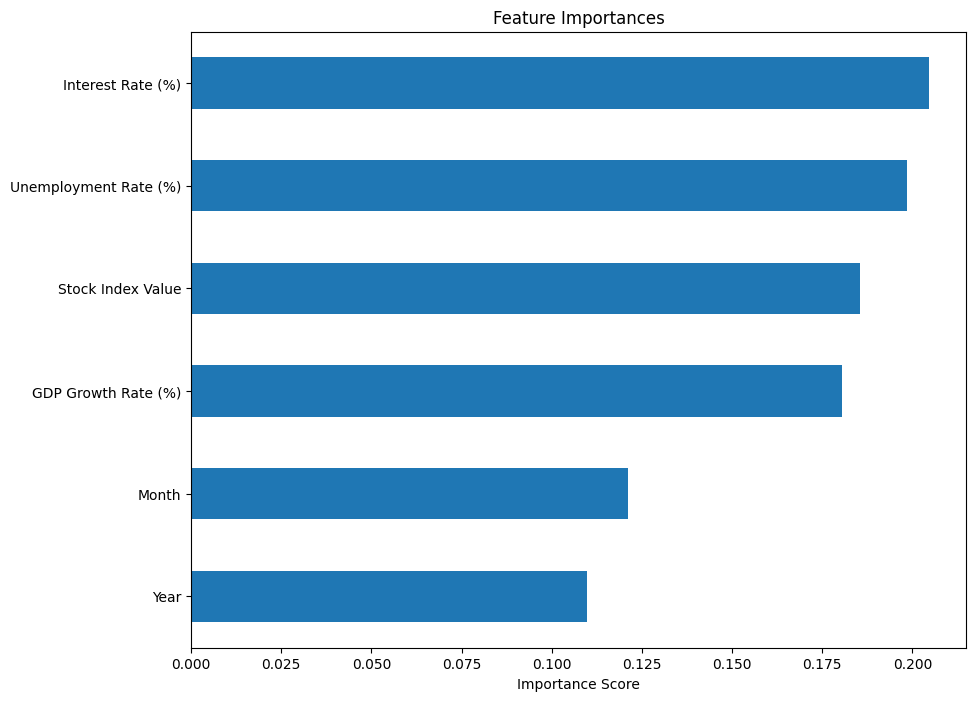

Top features: ['Interest Rate (%)', 'Unemployment Rate (%)', 'Stock Index Value', 'GDP Growth Rate (%)', 'Month', 'Year']


In [5]:
# Fit RandomForest for feature importance
X = df[['GDP Growth Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)', 'Stock Index Value', 'Year', 'Month']]
y = df['Inflation Rate (%)']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Plot feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.show()

# Select top features
top_features = importances.sort_values(ascending=False).head(6).index.tolist()
print("Top features:", top_features)

## Model Building (Regression)

In [6]:
# Split data
X = df[top_features]
y = df['Inflation Rate (%)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}

# Display results
results_df = pd.DataFrame(results).T
display(results_df)

# Choose best model
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
print(f'Best model: {best_model_name}')

,R2,RMSE,MAE
Linear Regression,-0.017994,2.861667,2.396545
Random Forest,0.008860,2.823671,2.345791
Gradient Boosting,-0.037399,2.888812,2.391389


Best model: Random Forest


## Model Building (Classification)

In [7]:
# Step 1: Create a classification target
threshold = df['Inflation Rate (%)'].median()
df['Inflation Category'] = (df['Inflation Rate (%)'] > threshold).astype(int)

# Step 2: Prepare data for classification
X = df[top_features]
y = df['Inflation Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a classification model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = clf.predict(X_test)

# Step 5: Calculate precision
precision = precision_score(y_test, y_pred)

# Step 6: Print precision
print(f"Precision: {precision:.2f}")

Precision: 0.62


## Deployment UI

In [8]:
# Simple Gradio UI for prediction
def predict_inflation(*inputs):
    try:
        arr = np.array(inputs).reshape(1, -1)
        arr = scaler.transform(arr)
        prediction = best_model.predict(arr)[0]
        return round(prediction, 2)
    except Exception as e:
        return f"Error: {str(e)}"

input_components = [gr.Number(label=feat) for feat in top_features]
gr.Interface(
    fn=predict_inflation,
    inputs=input_components,
    outputs=gr.Number(label='Predicted Inflation Rate (%)'),
    title='Inflation Predictor'
).launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
